In [1]:
from pathlib import Path

folders = list((Path.cwd() / "results" / "sceptr" / "eval").glob("*"))

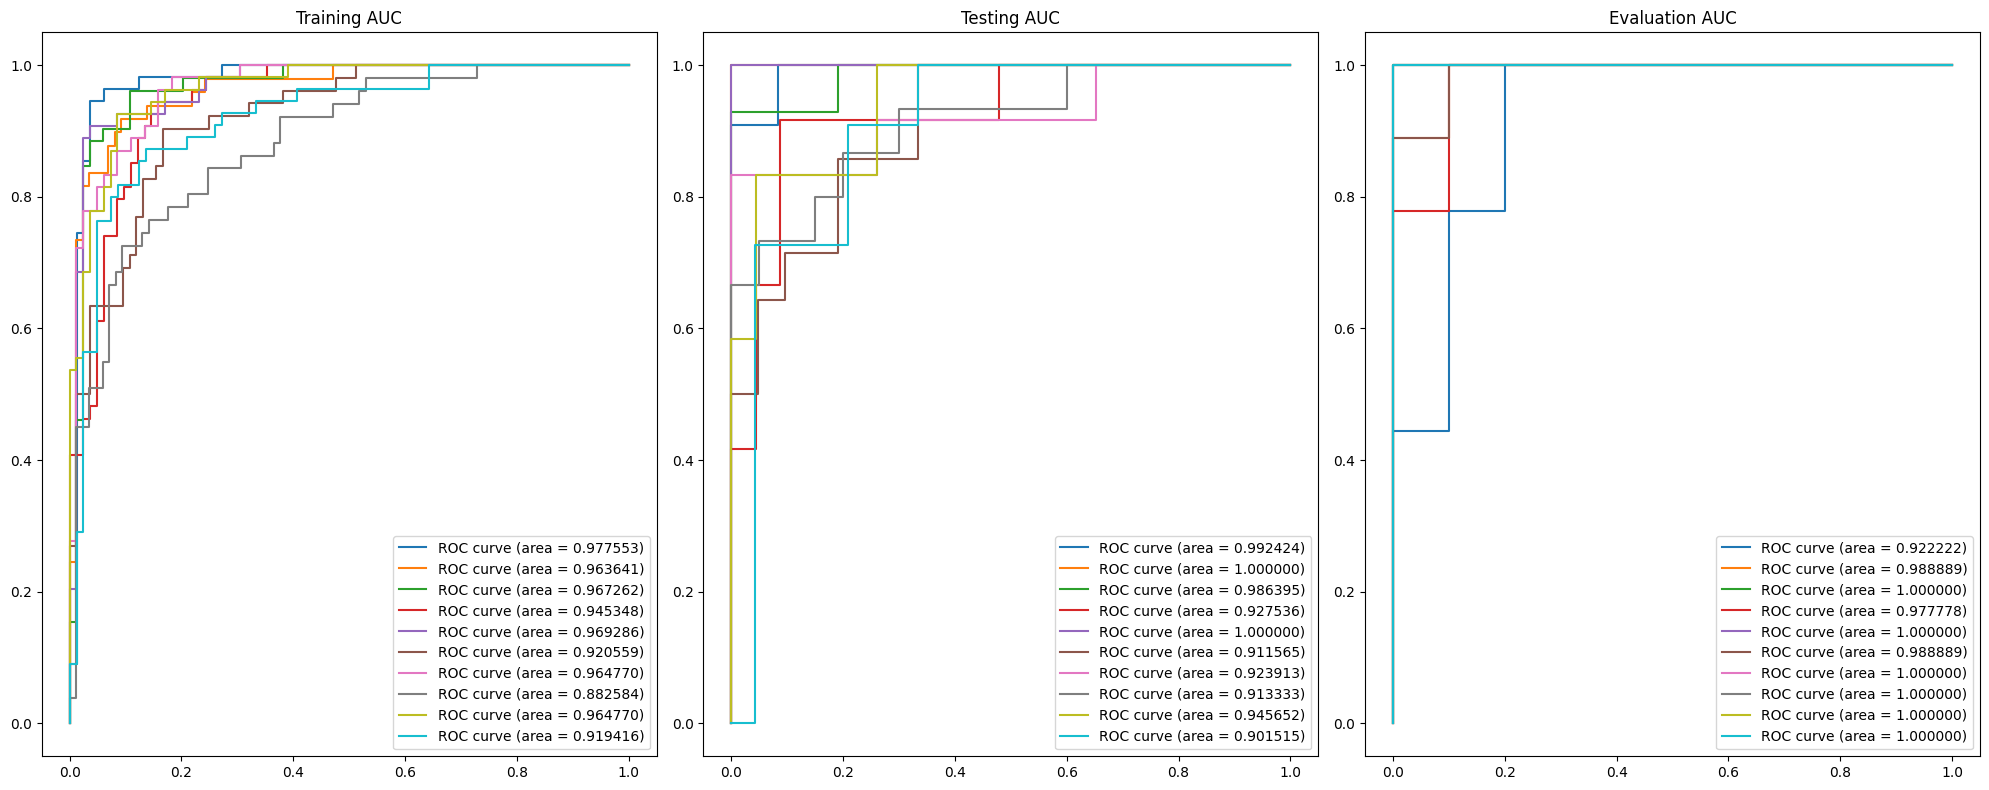

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt
import re

plt.rcParams['figure.figsize'] = [20, 8]
eval_pat = re.compile(r"eval-set-auc-(.*).csv")
fig, axs = plt.subplots(ncols = 3)

evaldata = []
aucs = []

for i, folder in enumerate(folders):
    eval_file = list(folder.glob("eval-set-auc-*.csv"))[0]
    eval_epoch = eval_pat.match(eval_file.name).group(1)
    auc_file = folder / f"eval-set-auc-{eval_epoch}.csv"
    traindir = folder / f"Epoch {eval_epoch}" / "train-preds.csv"
    testdir = folder / f"Epoch {eval_epoch}" / "test-preds.csv"

    df = pd.read_csv(traindir)
    fpr, tpr, threshold = roc_curve(df["actual"], df["preds"])
    auc = roc_auc_score(df["actual"], df['preds'])
    axs[0].plot(fpr, tpr, label = f"ROC curve (area = {auc:5f})", c = f"C{i}")
    axs[0].legend()
    axs[0].set_title("Training AUC")

    df = pd.read_csv(testdir)
    fpr, tpr, threshold = roc_curve(df["actual"], df["preds"])
    auc = roc_auc_score(df["actual"], df['preds'])
    axs[1].plot(fpr, tpr, label = f"ROC curve (area = {auc:5f})", c = f"C{i}")
    axs[1].legend()
    axs[1].set_title("Testing AUC")

    df = pd.read_csv(auc_file)
    fpr, tpr, threshold = roc_curve(df["actual"], df["preds"])
    auc = roc_auc_score(df["actual"], df['preds'])
    axs[2].plot(fpr, tpr, label = f"ROC curve (area = {auc:5f})", c = f"C{i}")
    axs[2].set_title("Evaluation AUC")
    axs[2].legend()
    evaldata.append(df)
    aucs.append(auc)

plt.tight_layout()
plt.show()

In [3]:
import numpy as np

bce = lambda pred, truth: np.mean(-(truth * np.log(pred) + (1 - truth) * np.log(1 - pred)))
losses = []
accs = []

for df in evaldata:
    losses.append(bce(df["preds"], df["actual"]))
    df["preds"] = df["preds"].map(lambda x: 0 if x < 0.5 else 1)
    accs.append(np.mean(df["preds"] == df["actual"]))

print (f"{round(np.min(losses), 3)} - {round(np.max(losses), 3)} ($\mu$: {round(np.mean(losses), 3)})")
print (f"{round(np.min(accs), 3)} - {round(np.max(accs), 3)} ($\mu$: {round(np.mean(accs), 3)})")
print (f"{round(np.min(aucs), 3)} - {round(np.max(aucs), 3)} ($\mu$: {round(np.mean(aucs), 3)})")

0.215 - 0.545 ($\mu$: 0.326)
0.842 - 1.0 ($\mu$: 0.947)
0.922 - 1.0 ($\mu$: 0.988)


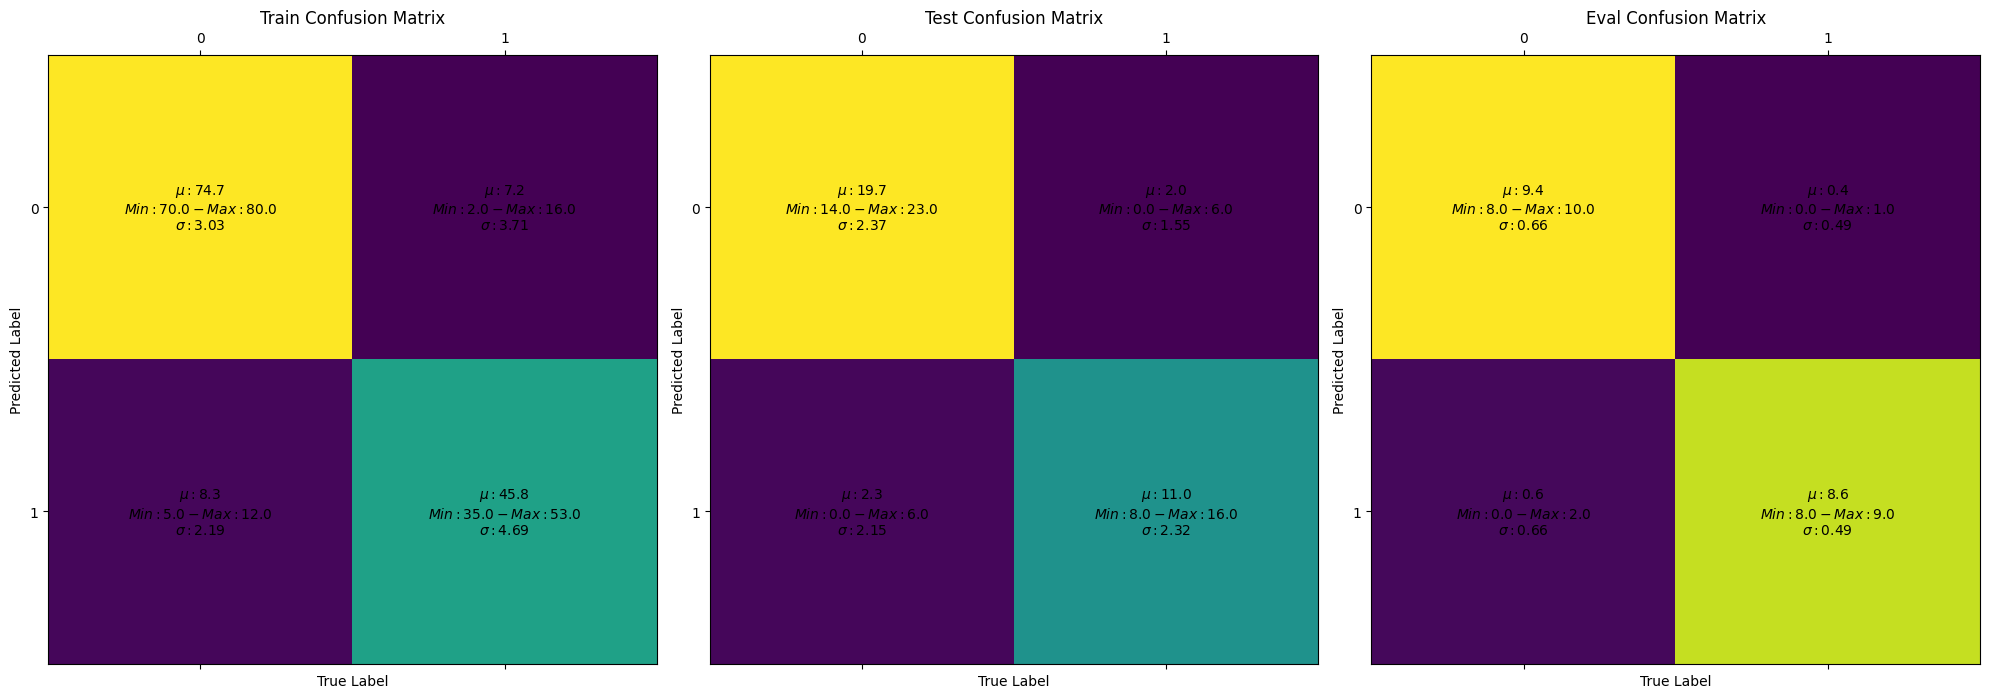

In [4]:
import numpy as np

fig, axs = plt.subplots(ncols = 3)
cms = {"train": [], "test": [], "eval": []}

for folder in folders:
    eval_file = list(folder.glob("eval-set-auc-*.csv"))[0]
    bestepoch = eval_pat.match(eval_file.name).group(1)
    dirs = folder / f"Epoch {bestepoch}"
    data = {"train": None, "test": None, "eval": None}

    for i in list(dirs.glob("*-preds.csv")):
        info = i.name.replace("-preds.csv", "")
        df = pd.read_csv(i)
        data[info] = df
    
    data["eval"] = pd.read_csv(folder / f"eval-set-auc-{bestepoch}.csv")
    
    for i, key in enumerate(list(data.keys())):
        conf = np.zeros((2, 2))
        df_ = data[key].copy()
        df_["preds"] = df_["preds"].map(lambda x: 1 if x >= 0.5 else 0)
        conf[0, 0] = ((df_["preds"] == 0) & (df_["actual"] == 0)).sum()
        conf[0, 1] = ((df_["preds"] == 0) & (df_["actual"] == 1)).sum()
        conf[1, 0] = ((df_["preds"] == 1) & (df_["actual"] == 0)).sum()
        conf[1, 1] = ((df_["preds"] == 1) & (df_["actual"] == 1)).sum()
        cms[key].append(conf)

confmax = {k: np.max(i, axis = 0) for k, i in cms.items()}
confmean = {k: np.mean(i, axis = 0) for k, i in cms.items()}
confmin = {k: np.min(i, axis = 0) for k, i in cms.items()}
confstd = {k: np.std(i, axis = 0) for k, i in cms.items()}
for i, key in enumerate(list(confmean.keys())):
    axs[i].matshow(confmean[key])
    for x in range(2):
        for y in range(2):
            axs[i].text(x, y, f"$\mu: {round(confmean[key][y, x], 2)}$\n$Min: {round(confmin[key][y, x], 2)} - Max: {round(confmax[key][y, x], 2)}$\n$\sigma: {round(confstd[key][y, x], 2)}$", va = "center", ha = "center")

    axs[i].set_xlabel("True Label")
    axs[i].set_ylabel("Predicted Label")
    axs[i].set_title(f"{key.title()} Confusion Matrix")

plt.tight_layout()
plt.show()